# Diabetes Prediction Using Logistic Regression and Random Forest

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE   # NEW
from imblearn.pipeline import Pipeline as ImbPipeline  # SMOTE-compatible pipeline
from sklearn.metrics import recall_score, precision_score, f1_score

# 2. Load Dataset

In [2]:
df = pd.read_csv(r"C:\Users\Lohith\Downloads\diabetes.csv")   # replace with your dataset filename
print("Shape:", df.shape)
print(df.head())

Shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


# 3. Feature Engineering

In [3]:
df["BMI_Age"] = df["BMI"] * df["Age"]
df["Insulin_log"] = df["Insulin"].replace(0, np.nan).apply(
    lambda x: np.log1p(x) if pd.notna(x) else np.nan
)
if "SkinThickness" in df.columns:
    df = df.drop("SkinThickness", axis=1)

X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Logistic Regression (Baseline)

In [4]:
logreg_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

logreg_pipeline.fit(X_train, y_train)
y_pred_log = logreg_pipeline.predict(X_test)

acc_log = accuracy_score(y_test, y_pred_log)
report_log = classification_report(y_test, y_pred_log, output_dict=True)

print("\n=== Logistic Regression (Baseline) ===")
print("Accuracy:", acc_log)
print(classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))


=== Logistic Regression (Baseline) ===
Accuracy: 0.7467532467532467
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       100
           1       0.62      0.74      0.67        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.76      0.75      0.75       154

Confusion Matrix:
 [[75 25]
 [14 40]]


# 5. RandomForest with Hyperparameter Tuning

In [5]:
rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

param_grid = {
    "model__n_estimators": [200, 300, 400],
    "model__max_depth": [6, 8, 10, None],
    "model__min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

print("\n=== RandomForest (Best Params) ===")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", acc_rf)
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

=== RandomForest (Best Params) ===
Best Parameters: {'model__max_depth': 6, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Accuracy: 0.7662337662337663
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       100
           1       0.64      0.76      0.69        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.78      0.77      0.77       154

Confusion Matrix:
 [[77 23]
 [13 41]]


# 6. RandomForest with SMOTE Oversampling

In [6]:
smote_rf_pipeline = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        random_state=42
    ))
])

smote_rf_pipeline.fit(X_train, y_train)
y_pred_smote = smote_rf_pipeline.predict(X_test)

acc_smote = accuracy_score(y_test, y_pred_smote)
report_smote = classification_report(y_test, y_pred_smote, output_dict=True)

print("\n=== RandomForest + SMOTE ===")
print("Accuracy:", acc_smote)
print(classification_report(y_test, y_pred_smote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))


=== RandomForest + SMOTE ===
Accuracy: 0.7467532467532467
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       100
           1       0.62      0.74      0.67        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.76      0.75      0.75       154

Confusion Matrix:
 [[75 25]
 [14 40]]


# 7. Comparison Table

In [7]:
results = pd.DataFrame({
    "Model": [
        "Logistic Regression + FE",
        "RandomForest Tuned + FE",
        "RandomForest + SMOTE + FE"
    ],
    "Accuracy": [acc_log, acc_rf, acc_smote],
    "Recall (Class 1)": [
        report_log["1"]["recall"],
        report_rf["1"]["recall"],
        report_smote["1"]["recall"]
    ]
})

print("\n=== Model Comparison ===")
print(results)


=== Model Comparison ===
                       Model  Accuracy  Recall (Class 1)
0   Logistic Regression + FE  0.746753          0.740741
1    RandomForest Tuned + FE  0.766234          0.759259
2  RandomForest + SMOTE + FE  0.746753          0.740741


# Using threshold to improve the recall

# Helper Function: Evaluate with Threshold

In [8]:
def evaluate_with_threshold(model, X_test, y_test, threshold=0.5):
    """Evaluate model at custom threshold."""
    # Get probabilities for class 1
    probs = model.predict_proba(X_test)[:, 1]
    # Apply threshold
    y_pred = (probs >= threshold).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return {"Threshold": threshold, "Accuracy": acc, "Recall": rec, "Precision": prec, "F1": f1}

# Logistic Regression Threshold Tuning

In [9]:
print("\n=== Logistic Regression Threshold Tuning ===")
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
log_results = []

for t in thresholds:
    res = evaluate_with_threshold(logreg_pipeline, X_test, y_test, threshold=t)
    log_results.append(res)

df_log = pd.DataFrame(log_results)
print(df_log)


=== Logistic Regression Threshold Tuning ===
   Threshold  Accuracy    Recall  Precision        F1
0        0.3  0.707792  0.925926   0.549451  0.689655
1        0.4  0.733766  0.888889   0.578313  0.700730
2        0.5  0.746753  0.740741   0.615385  0.672269
3        0.6  0.720779  0.611111   0.600000  0.605505
4        0.7  0.733766  0.500000   0.658537  0.568421


# RandomForest Threshold Tuning

In [10]:
print("\n=== RandomForest Tuned Threshold Tuning ===")
rf_results = []

for t in thresholds:
    res = evaluate_with_threshold(best_rf, X_test, y_test, threshold=t)
    rf_results.append(res)

df_rf = pd.DataFrame(rf_results)
print(df_rf)


=== RandomForest Tuned Threshold Tuning ===
   Threshold  Accuracy    Recall  Precision        F1
0        0.3  0.681818  0.870370   0.528090  0.657343
1        0.4  0.746753  0.851852   0.597403  0.702290
2        0.5  0.766234  0.759259   0.640625  0.694915
3        0.6  0.753247  0.537037   0.690476  0.604167
4        0.7  0.746753  0.407407   0.758621  0.530120


# Threshold Tuning Visualization for Diabetes Prediction

This section visualizes how **Accuracy, Recall, Precision, and F1-score** change across different thresholds for Logistic Regression and Random Forest models.  
The highlighted threshold shows the recommended value based on **maximum Recall (Logistic Regression)** or **best F1-score (Random Forest)**.

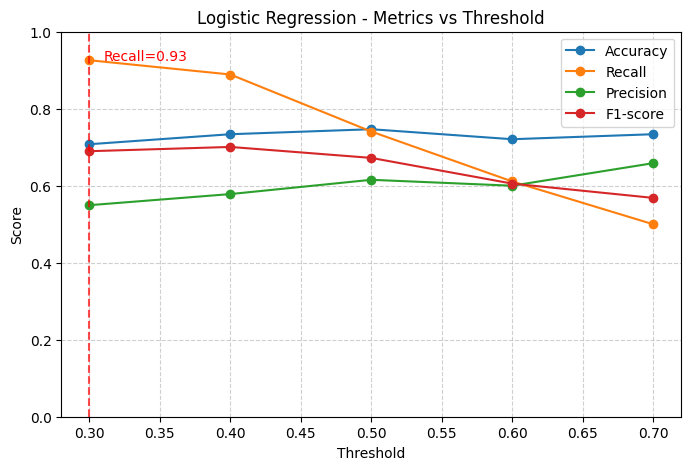

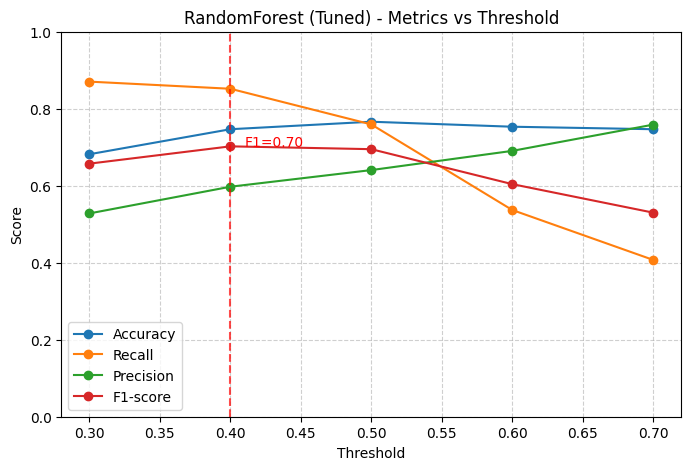

In [11]:
def plot_threshold_results(df, model_name, highlight_threshold=None, highlight_metric="Recall"):
    plt.figure(figsize=(8, 5))
    plt.plot(df["Threshold"], df["Accuracy"], marker="o", label="Accuracy")
    plt.plot(df["Threshold"], df["Recall"], marker="o", label="Recall")
    plt.plot(df["Threshold"], df["Precision"], marker="o", label="Precision")
    plt.plot(df["Threshold"], df["F1"], marker="o", label="F1-score")
    
    if highlight_threshold is not None:
        plt.axvline(x=highlight_threshold, color="red", linestyle="--", alpha=0.7)
        best_val = df.loc[df["Threshold"] == highlight_threshold, highlight_metric].values[0]
        plt.text(highlight_threshold + 0.01, best_val, f"{highlight_metric}={best_val:.2f}", color="red")
    
    plt.title(f"{model_name} - Metrics vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()

# Highlight threshold 0.3 for Logistic Regression (max Recall)
plot_threshold_results(df_log, "Logistic Regression", highlight_threshold=0.3, highlight_metric="Recall")

# Highlight threshold 0.4 for RandomForest (best F1)
plot_threshold_results(df_rf, "RandomForest (Tuned)", highlight_threshold=0.4, highlight_metric="F1")

# Save the model

In [14]:
import pickle

# Save Logistic Regression model (you can include the recommended threshold if you want)
logreg_data = {
    "model": logreg_pipeline,  # your trained pipeline
    "threshold": 0.3           # best threshold based on recall
}

with open("logreg_diabetes_model.pkl", "wb") as f:
    pickle.dump(logreg_data, f)

# Save Random Forest tuned model
rf_data = {
    "model": best_rf,           # best RF from GridSearch
    "threshold": 0.4            # best threshold based on F1
}

with open("rf_diabetes_model.pkl", "wb") as f:
    pickle.dump(rf_data, f)

print("Models saved successfully!")

Models saved successfully!


# I saved both files 
But the recommended file is only logreg_diabetes_model as it was suitable to this case

# Note 
I take help from GPT to improve my model only on the topics i know